> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from  filtered EMG data (should be highly unique). Thus, implement a basic ML model to link the EMG data back to the corresponding subject.  

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from presentation_sns_config import *
import pandas as pd
from kcs_ml_infr import *
from experiment_params import *

from IPython.display import display

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

# Filtered EMG Data Privacy Evaluation
>Linking EMG Data to Participants
1. Does the channel matter / improve performance? Within the same block (assuming different blocks have the strap re-put on) then presumably the same muscles should act in similar ways.  __Just do PCA on it and don't worry about it__
2. Does the condition matter? Presumably, but the question is how much.  __Only look at condition for conditions that changed performance (eg learning rate speed)__
3. Ways to compress the input data: PCA/LDA/nonlinearversion, or norms of the vectors... is it even necessary / beneficial to performance.  __Focus on just PCA for now__
4. __No standard scaler since negative filtered EMG data has no meaning__
1. Actually, do NMF instead of PCA since PCA can result in negative values which don't have any meaning for EMG data

## 1) Create Envelope of Filtered EMG Data

In [2]:
# Dont rerun this code since it's already been done and also takes forever
if 0:
    t0 = time.time()

    emg_data_df1 = pd.read_csv("Data\emg_full_data1.csv")
    emg_labels_df1 = pd.read_csv("Data\emg_full_labels1.csv")
    emg_data_df2 = pd.read_csv("Data\emg_full_data2.csv")
    emg_labels_df2 = pd.read_csv("Data\emg_full_labels2.csv")

    t1 = time.time()
    total = t1-t0  
    print(total)

    emg_data_df = pd.concat((emg_data_df1, emg_data_df2))
    emg_labels_df = pd.concat((emg_labels_df1, emg_labels_df2))
    emg_data_df.drop('Unnamed: 0', axis=1, inplace=True)
    emg_labels_df.drop('Unnamed: 0', axis=1, inplace=True)
    labels_df = pd.DataFrame(emg_labels_df['Subject'].map(key_to_num))

    t0 = time.time()

    plt.plot(emg_data_df.iloc[0, :])
    plt.show()

    t1 = time.time()
    total = t1-t0  
    print(total)

    # Do a crude moving average with no overlap
    envelope_df50 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//50, axis=1).mean()
    envelope_df100 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//100, axis=1).mean()
    envelope_df150 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//150, axis=1).mean()
    envelope_df200 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//200, axis=1).mean()
    envelope_df250 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//250, axis=1).mean()
    envelope_df300 = emg_data_df.groupby(np.arange(len(emg_data_df.columns))//250, axis=1).mean()

    envelope_df50.to_csv("Data\envelope_df50.csv")
    envelope_df100.to_csv("Data\envelope_df100.csv")
    envelope_df150.to_csv("Data\envelope_df150.csv")
    envelope_df200.to_csv("Data\envelope_df200.csv")
    envelope_df250.to_csv("Data\envelope_df250.csv")
    envelope_df300.to_csv("Data\envelope_df300.csv")

    # This is substantially different than the original lol
    plt.plot(envelope_df100.iloc[0, :])
    plt.xlabel("Downsampled Time")
    plt.ylabel("EMG Reading")
    plt.title("Smoothed EMG Data (100 ms windows)")
    plt.show()

    ex = emg_data_df.iloc[0, :].rolling(window=100).mean().dropna().plot()

# Load In Data

Load in the other data
> This cell takes ~2 minutes to run as a heads up

In [3]:
emg_labels_df1 = pd.read_csv("Data\emg_full_labels1.csv")
emg_labels_df2 = pd.read_csv("Data\emg_full_labels2.csv")
emg_labels_df = pd.concat((emg_labels_df1, emg_labels_df2))

try:
    emg_labels_df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    # Masterful code here
    print("NO UNNAMED COLUMN DETECTED!")

print(emg_labels_df.shape)
emg_labels_df.head()

(14336, 3)


,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [4]:
labels_df = pd.DataFrame(emg_labels_df['Subject'].map(key_to_num))
labels_df.head()

,Subject
0,0
1,0
2,0
3,0
4,0


In [5]:
# The below needs to be run on raw EMG data not the filtered data.  Don't waste time running it again
assert(1==0)

AssertionError: 

# Filtered EMG Data Privacy Evaluation
>Linking EMG Data to Participants
1. Does the channel matter / improve performance? Within the same block (assuming different blocks have the strap re-put on) then presumably the same muscles should act in similar ways.  __Just do PCA on it and don't worry about it__
2. Does the condition matter? Presumably, but the question is how much.  __Only look at condition for conditions that changed performance (eg learning rate speed)__

## Load the Envelopes of Filtered EMG Data

In [6]:
envelope_df50 = pd.read_csv("Data\envelope_df50.csv")
envelope_df100 = pd.read_csv("Data\envelope_df100.csv")
envelope_df150 = pd.read_csv("Data\envelope_df150.csv")
envelope_df200 = pd.read_csv("Data\envelope_df200.csv")
envelope_df250 = pd.read_csv("Data\envelope_df250.csv")
envelope_df300 = pd.read_csv("Data\envelope_df300.csv")

raw_envs = [envelope_df50, envelope_df100, envelope_df150, envelope_df200, envelope_df250, envelope_df300]
all_envs = [env.drop('Unnamed: 0', axis=1) for env in raw_envs]

print("100")
print(all_envs[1].shape)
all_envs[1].head()

100
(7168, 208)


,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,14.129705,11.959808,28.685874,33.823858,42.311438,22.872970,28.686864,91.792338,26.813570,28.583164,...,43.676011,39.113891,27.947874,31.573392,36.614566,35.604320,51.523493,31.292127,59.277122,51.997711
1,13.895036,12.063848,22.026072,27.027048,59.187831,23.013614,30.960467,81.718608,29.116355,28.694447,...,41.396844,44.348191,31.188022,30.580405,32.773796,39.768986,51.494867,29.641406,47.146682,58.581918
2,13.214033,15.229451,23.956005,25.832507,48.218284,29.437285,27.001414,35.878805,29.420835,31.587059,...,27.507856,35.271588,28.060107,24.463167,30.750010,39.033112,31.714344,17.286340,30.174009,49.750919
3,13.979167,16.414878,19.550628,21.984005,32.083749,26.856702,23.001818,21.776800,23.041464,24.603026,...,21.163787,27.844200,26.265045,24.563413,29.984113,35.764448,23.072423,15.670036,22.936556,38.122263
4,10.168381,10.501039,12.856129,16.059131,20.128401,13.435236,16.672336,18.134148,20.744904,21.606347,...,14.751494,19.967234,19.091210,16.293000,20.945203,25.093296,14.147869,10.369884,15.788238,26.206604


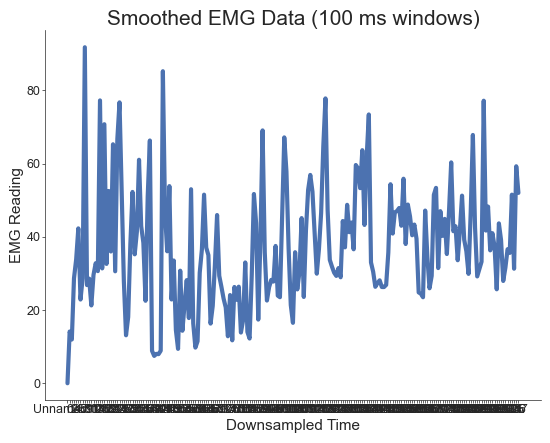

In [7]:
plt.plot(envelope_df100.iloc[0, :])
plt.xlabel("Downsampled Time")
plt.ylabel("EMG Reading")
plt.title("Smoothed EMG Data (100 ms windows)")
plt.show()

# Make ML Model Attack
> Trying without doing any sample reduction just to see if the run times are bearable... if so, then maybe don't need to do any PCA and can save myself the trouble

In [8]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [14]:
all_envs_res_df = pd.DataFrame()

for idx, my_env_df in enumerate(all_envs):
    print(f"Envelope: {idx+1} of {len(all_envs)}")
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(my_env_df, labels_df, stratification=False)
    y_train = np.ravel(y_train)

    print("X_train")
    print(X_train.shape)
    #display(X_train.head())
    
    for model_num, model in enumerate(my_models):
        print(f"Model: {model_num+1} of {len(my_models)}")
        all_envs_res_df = train_model(model, X_train, y_train, cv, all_envs_res_df)

all_envs_res_df.head()    

Envelope: 1 of 6


ValueError: Found input variables with inconsistent numbers of samples: [7168, 14336]

In [ ]:
print(all_envs_res_df.shape)

In [ ]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])

# THIS DOES NOT ITER THROUGH ALL ENVELOPES RIGHT NOW
for model_num, model in enumerate(my_models):
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)
    
test_df.head(100)

In [ ]:
all_envs_res_df.reset_index(inplace=True)
all_envs_res_df.drop('index', axis=1, inplace=True)
all_envs_res_df.head()

In [ ]:
# Not plotting all 7 model right now
lr_df = all_envs_res_df[all_envs_res_df['Algorithm']=='LogisticRegression()']
knn_df = all_envs_res_df[all_envs_res_df['Algorithm']=='KNeighborsClassifier()']
svc_df = all_envs_res_df[all_envs_res_df['Algorithm']=='LinearSVC()']
dt_df = all_envs_res_df[all_envs_res_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = all_envs_res_df[all_envs_res_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
envir_list = [50, 100, 150, 200, 250, 300]
my_x_updates = envir_list

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[:, 2], label='SVC')
plt.plot(my_x_updates, dt_df.iloc[:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[:, 2], label='GBC')

plt.scatter(my_x_updates, lr_df.iloc[:, 2])#, label='LogReg')
plt.scatter(my_x_updates, knn_df.iloc[:, 2])#, label='KNN')
plt.scatter(my_x_updates, svc_df.iloc[:, 2])#, label='SVC')
plt.scatter(my_x_updates, dt_df.iloc[:, 2])#, label='DTree')
plt.scatter(my_x_updates, gbt_df.iloc[:, 2])#, label='GBC')
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Filtering Window Size (ms)')
plt.ylabel('Training Accuracy')
plt.title('Adversary Linkage Capability as a function of Filtering Window Size')
plt.legend(loc='best')
plt.show()

In [ ]:
envir_list = [50, 100, 150, 200, 250, 300]
my_x_updates = envir_list

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[:, 2], label='SVC')
plt.plot(my_x_updates, dt_df.iloc[:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[:, 2], label='GBC')

plt.scatter(my_x_updates, lr_df.iloc[:, 2])#, label='LogReg')
plt.scatter(my_x_updates, knn_df.iloc[:, 2])#, label='KNN')
plt.scatter(my_x_updates, svc_df.iloc[:, 2])#, label='SVC')
plt.scatter(my_x_updates, dt_df.iloc[:, 2])#, label='DTree')
plt.scatter(my_x_updates, gbt_df.iloc[:, 2])#, label='GBC')
plt.yticks(np.arange(40, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Filtering Window Size (ms)')
plt.ylabel('Training Accuracy')
plt.title('Adversary Linkage Capability as a function of Filtering Window Size')
plt.legend(loc='lower left')
plt.show()

This is about what we would expect, although there is significant variation between models.  Generally, a smaller filtering window acts as less dimensionality reduction, and therefore the most information is preserved.  High filtering windows get rid of the most information and thus should have the lowest accuracies.  Perhaps we ought to test the decoder accuracy with differing window sizes, but I think that would be difficult to verify given the co-adaptive nature of the signal collection.

In [ ]:
assert(1==0)

## Investigate How Performance Changes Per Update
> E.g. as we use later intervals (note, not more intervals, just the later ones), does the EMG performance linking improve? Intuitively it should not.

In [ ]:
print(update_ix)
print()

# Scale update_ix to be for the new envelope_df, as it is currently meant for the original dataset
env_update_ix = np.array(np.ceil(update_ix/20770*envelope_df.shape[1]), dtype='int')
print(env_update_ix)

In [ ]:
def nth_emg_model(nth_emg_df, emg_label_df, n, my_models, my_metrics_cols=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds', 'N'], cv=5, test=True):
    ''''''

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(nth_emg_df, emg_label_df)
    y_train = np.ravel(y_train)

    dec_res_df = pd.DataFrame(columns=my_metrics_cols)
    #print("TRAINING")
    for model_num, model in enumerate(my_models):
        #print(f"{model_num} of {len(my_models)}")
        dec_res_df = train_model(model, X_train, y_train, cv, dec_res_df, dec_num=n)
        
    test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
    if test:
        #print("TESTING")
        for model in my_models:
            #print(f"{model_num} of {len(my_models)}")
            test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv, dec_num=n)
            
    return dec_res_df, test_df

This cell also takes forever to run too lol
> ONLY 18 updates because here we have to take full intervals as opposed to just grabbing the value at the update time (19 update indices and thus 18 intervals)

In [ ]:
test_df = pd.DataFrame(columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds', 'N'])
test_df.head()

for i in range(19):
    print(f"{i} of 18")
    if i==18:
        pass
    else:
        current_emg_df = envelope_df.iloc[:, env_update_ix[i]:env_update_ix[i+1]]
        current_dec_res_df, current_test_df = nth_emg_model(current_emg_df, labels_df, i, my_models, test=True)
        test_df = pd.concat((test_df, current_test_df))

In [ ]:
test_df.head(7)

In [ ]:
lr_df = test_df[test_df['Algorithm']=='LogisticRegression()']
knn_df = test_df[test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = test_df[test_df['Algorithm']=='LinearSVC()']
dt_df = test_df[test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = test_df[test_df['Algorithm']=='GradientBoostingClassifier()']

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(list(range(18)), lr_df.iloc[:, 5], label='LogReg')
plt.plot(list(range(18)), knn_df.iloc[:, 5], label='KNN')
plt.plot(list(range(18)), svc_df.iloc[:, 5], label='SVC')
plt.plot(list(range(18)), dt_df.iloc[:, 5], label='DTree')
plt.plot(list(range(18)), gbt_df.iloc[:, 5], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of EMG Update Interval')
plt.legend(loc='best')
plt.show()

Note the massive drop at the last update is because the last update is not the same size as the rest of the updates, it is much smaller and thus the drop in performance.